# Спортивный анализ данных. Платформа Kaggle

## Урок 4. Feature Engineering, Feature Selection.

Если будете решать ДЗ на отдельном датасете (не датасет из соревнования) - то использовать датасет из ДЗ2, IEEE-Fraud-Detection Challenge.

Задание 0: выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

Задание 2: сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

Задание 3: преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

Задание 4: преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

Задание 5: для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

Задание 6: использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

Задание 7: (опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.

In [645]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as catb
import matplotlib.pyplot as plt
import shap

from datetime import datetime, timedelta
from tqdm import tqdm
from typing import List, Tuple
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.simplefilter("ignore")
%matplotlib inline

### Загрузка данных

In [646]:
rs = 47 # random_state

In [647]:
test = pd.read_csv("assignment_test.csv")
test.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [648]:
train = pd.read_csv("assignment_train.csv")
train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [761]:
#train.info(max_cols=500)

In [650]:
# Целевая переменная, категориальные признаки и исключаемые признаки
target = "isFraud"
cat_features = np.hstack((train.select_dtypes("object").columns.tolist(), 
                         ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']))
drop_features = [target, 'TransactionID']

In [651]:
# Категориальные признаки подготавливаем для catboost
train[cat_features] = train[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)

#### Задание 0: 
выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

In [652]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samples: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true, n_samples=n_samples)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [653]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    """
    Графическое отображение важности признаков
    
    Parameters
    ----------
    feature_names: Имена признаков

    feature_importances: Значения важности признаков
    
    get_top: Если задано, то указывает число отображаемых признаков
    """
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances[:get_top]) * 0.355))
    sns.barplot(feature_importances['importance'][:get_top], feature_importances['feature'][:get_top])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    #if get_top is not None:
    #    return feature_importances['feature'][:get_top].tolist()

In [654]:
def fit_predict_value(i_train, i_test):
    """
    Обучение модели и оценка предсказаний с возвратом модели и разбитых выборок

    Parameters
    ----------
    i_train: Обучаемая выборка

    i_test: Тестовая выборка

    Returns
    -------
    model: Модель
    x_train: Подвыборка обучения
    y_train: Подвыборка меток обучения
    x_valid: Подвыборка валидационная
    y_valid: Подвыборка меток валидационная
    x_test: Подвыборка тестовая 
    y_test: Подвыборка меток тестовая
    x_public: Подвыборка паблик лидер-борд
    y_public: Подвыборка меток паблик лидер-борд

    """
    np.random.seed(rs)

    cat_features_sub = list(set(i_train.columns) & set(cat_features))
    train_drop_features_sub = list(set(i_train.columns) & set(drop_features))
    test_drop_features_sub = list(set(i_test.columns) & set(drop_features))
    
    x_train, x_valid = train_test_split(i_train.drop(train_drop_features_sub, axis=1), train_size=0.7, shuffle=True, random_state=rs)
    y_train, y_valid = train_test_split(i_train[target], train_size=0.7, shuffle=True, random_state=rs)
    x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=rs, shuffle=True)
    y_valid, y_test = train_test_split(y_valid, train_size=0.5, random_state=rs, shuffle=True)
    x_public = i_test.drop(test_drop_features_sub, axis=1)
    y_public = i_test[target]

    #print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    #print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
    #print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
    #print("x_public.shape = {} rows, {} cols".format(*x_public.shape))

    model = catb.CatBoostClassifier(cat_features=cat_features_sub, eval_metric='AUC', n_estimators=50, 
                                    max_depth=5, early_stopping_rounds=10, learning_rate=0.1,
                                    silent=True, random_state=rs)
    
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
    y_test_pred = model.predict_proba(x_test)[:, 1]
    
    print("train roc_auc =", roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    print("valid roc_auc =", roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
    print("test roc_auc =", roc_auc_score(y_test, y_test_pred))
    print("public roc_auc =", roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))
    print("confidence_interval =", calculate_confidence_interval(
        create_bootstrap_metrics(y_test, y_test_pred, roc_auc_score)))
    
    show_feature_importances(x_train.columns, model.get_feature_importance(), get_top=30)
    
    return model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public, y_public

In [655]:
def fit_predict(i_train, i_test):
    """
    Обучение модели и оценка предсказаний

    Parameters
    ----------
    i_train: Обучаемая выборка

    i_test: Тестовая выборка
    """
    _, _, _, _, _, _, _, _, _ = fit_predict_value(i_train, i_test)

train roc_auc = 0.9095643159693049
valid roc_auc = 0.9128497607853696
test roc_auc = 0.8897124009938526
public roc_auc = 0.8724215506357542
confidence_interval = (0.8624369089375139, 0.9135117149489461)


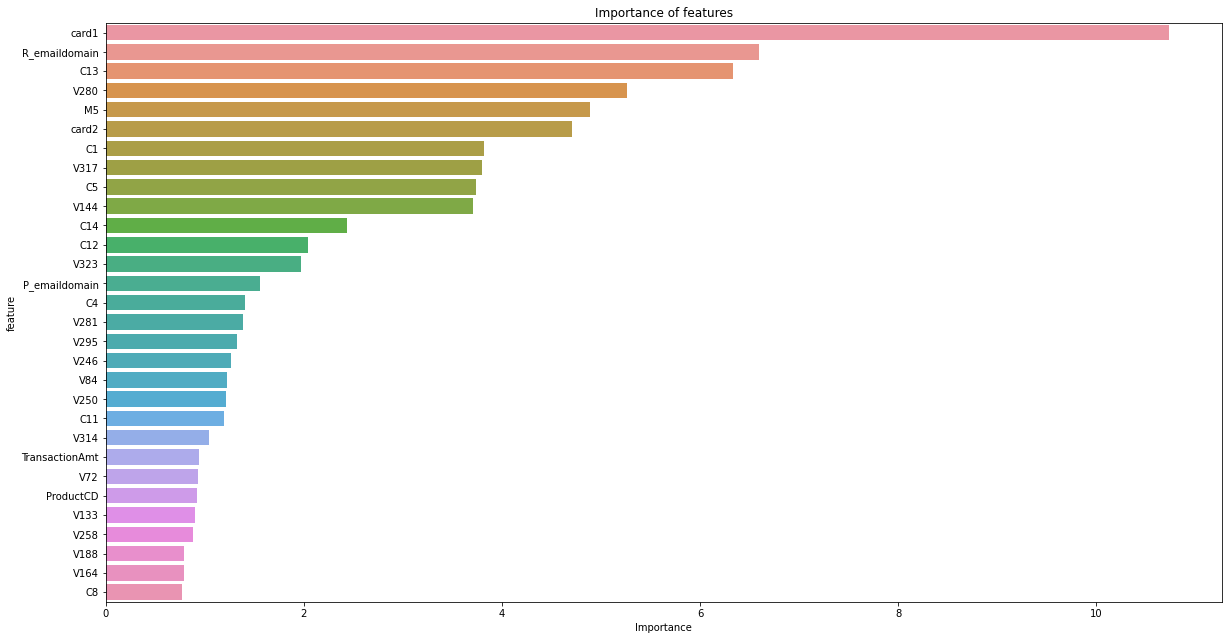

Wall time: 5.39 s


In [656]:
%%time
fit_predict(train, test)

Зафиксируем базовое качество модели 0.8724215506357542 с доверительным интервалом (0.8624369089375139, 0.9135117149489461)

#### Задание 1: 
признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [657]:
def add_dates(data):
    """
    Добавление признаков с датами

    Parameters
    ----------
    data: Исходная выборка

    Returns
    -------
    data: Результирующая выборка
    """
    data['TransactionDT_date'] = [datetime.strptime('2017-12-01', '%Y-%m-%d') + timedelta(seconds=x) 
                                  for x in data['TransactionDT']]
    data['TransactionDT_year'] = [x.year for x in data['TransactionDT_date']]
    data['TransactionDT_month'] = [x.month for x in data['TransactionDT_date']]
    data['TransactionDT_weekday'] = [x.weekday() for x in data['TransactionDT_date']]
    data['TransactionDT_day'] = [x.day for x in data['TransactionDT_date']]
    data['TransactionDT_hour'] = [x.hour for x in data['TransactionDT_date']]
    
    return data

In [658]:
train = add_dates(train)
test = add_dates(test)

train roc_auc = 0.9104576249182808
valid roc_auc = 0.9158677743719321
test roc_auc = 0.891317496238058
public roc_auc = 0.8742862774411431
confidence_interval = (0.8648791282781491, 0.915291312919385)


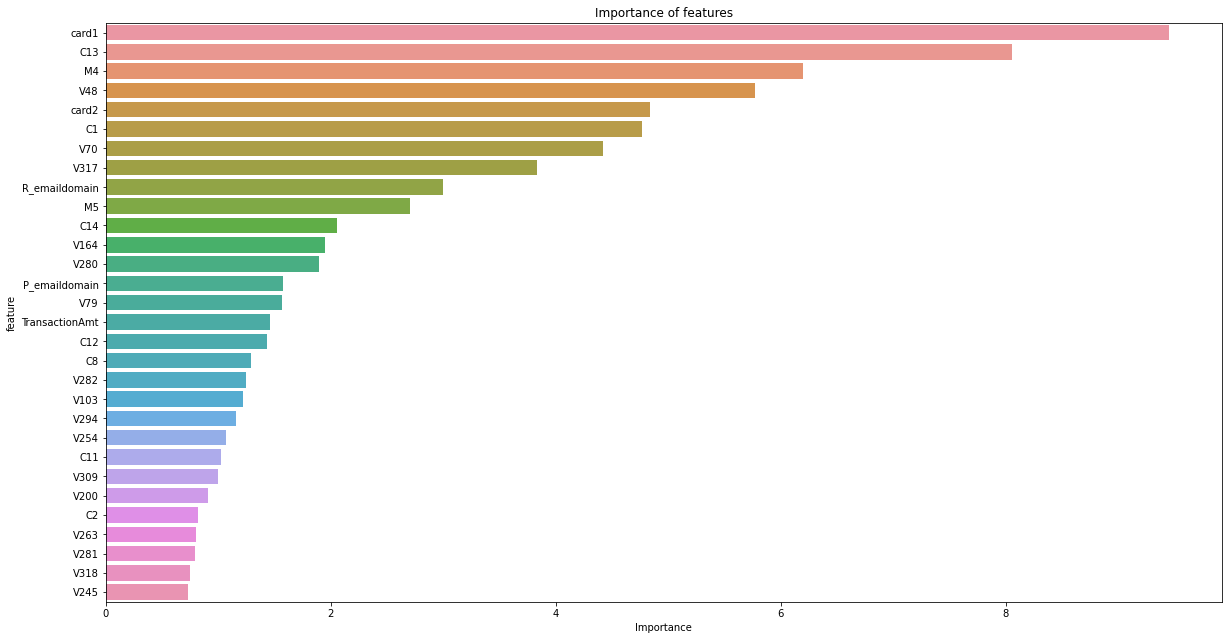

Wall time: 5.76 s


In [659]:
%%time
fit_predict(train, test)

Добавление новых признаков с датами позволило немного улучшить качество модели: 0.8742862774411431 с доверительным интервалом (0.8648791282781491, 0.915291312919385). При этом сами новые признаки не попали даже в топ 30 важных признаков.

#### Задание 2: 
сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

In [660]:
def add_gr_fields(data, gr_field, agg_field, oper):
    """
    Добавление сгруппированных признаков

    Parameters
    ----------
    data: Исходная выборка
    
    gr_field: Группируемые признаки
    
    agg_field: Агрегируемые признаки
    
    oper: Операция аггрегации

    Returns
    -------
    data: Результирующая выборка
    """
    new_agg_field = f'{agg_field}_{gr_field}_{oper}'
    new_ratio_field = f"{agg_field}_{gr_field}/{oper}"
    new_diff_field = f"{agg_field}_{gr_field}-{oper}"
    
    gr = data.groupby([gr_field]).agg({agg_field:oper}).rename(columns={agg_field:new_agg_field})
    data = data.merge(gr, on=gr_field, how='left')
    data[new_ratio_field] = data[agg_field] / data[new_agg_field]
    data[new_diff_field] = data[agg_field] - data[new_agg_field]
    
    return data

In [661]:
def add_gr_card(data):
    """
    Добавление сгруппированных признаков по полям card1, ..., card6.

    Parameters
    ----------
    data: Исходная выборка

    Returns
    -------
    data: Результирующая выборка
    """
    for i in range(1, 7):
        data = add_gr_fields(data=data, gr_field=f'card{i}', agg_field='TransactionAmt', oper='mean')
    return data

In [662]:
train = add_gr_card(train)
test = add_gr_card(test)

train roc_auc = 0.9114744788256656
valid roc_auc = 0.912985030963279
test roc_auc = 0.8920284741096738
public roc_auc = 0.8725718226256316
confidence_interval = (0.8644423385975107, 0.9170941733066905)


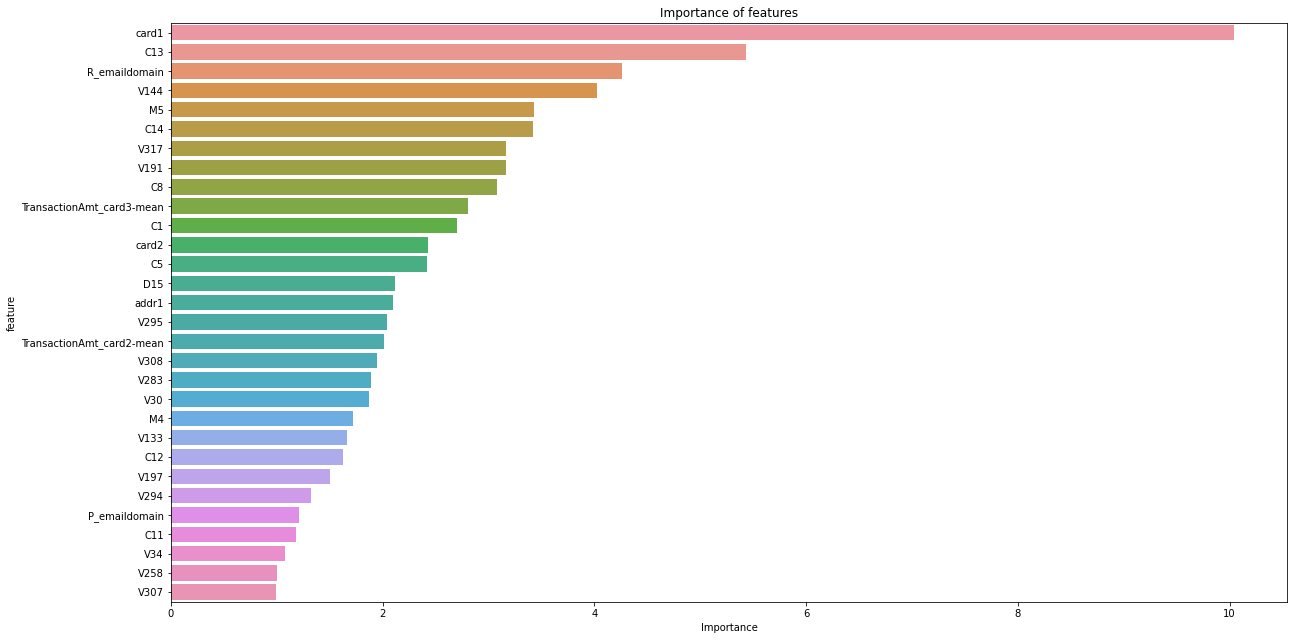

Wall time: 5.99 s


In [663]:
%%time
fit_predict(train, test)

Добавление новых признаков ухудшило качество модели: 0.8725718226256316 с доверительным интервалом (0.8644423385975107, 0.9170941733066905). При этом пара признаков попала в топ 20 важных признаков.

#### Задание 3: 
преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

In [664]:
def frequency_encoding(data, field):
    """
    Добавление признаков с помощью Frequency Encoding

    Parameters
    ----------
    data: Исходная выборка
    
    field: Обрабатываемое поле

    Returns
    -------
    data: Результирующая выборка
    """

    data[f"{field}_freq_enc"] = data[field].map(data[field].value_counts(normalize=True))
    return data

In [665]:
def frequency_encoding_cardx(data):
    """
    Добавление признаков с помощью Frequency Encoding для полей card1, ..., card6

    Parameters
    ----------
    data: Исходная выборка

    Returns
    -------
    data: Результирующая выборка
    """

    for i in range(1, 7):
        data = frequency_encoding(data=data, field=f'card{i}')
    return data

In [666]:
train = frequency_encoding_cardx(train)
test = frequency_encoding_cardx(test)

train roc_auc = 0.9113960793280936
valid roc_auc = 0.9199207019033613
test roc_auc = 0.8953836014324542
public roc_auc = 0.8712152462688387
confidence_interval = (0.8689869707318643, 0.918166499378302)


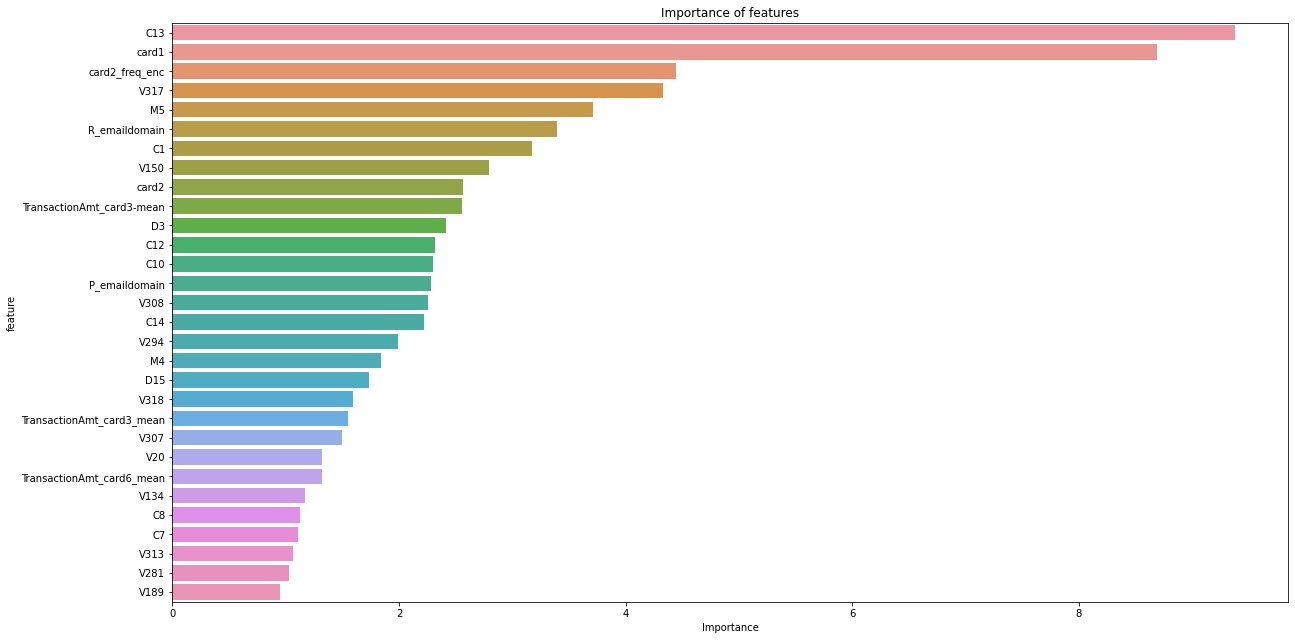

Wall time: 5.87 s


In [667]:
%%time
fit_predict(train, test)

Добавление новых признаков снова ухудшило качество модели: 0.8712152462688387, с доверительным интервалом (0.8689869707318643, 0.918166499378302). При этом один из новых признаков попал в топ 10 важных признаков.

#### Задание 4: 
преобразовать признак TransactionAmt в логарифм признака, выделить дробную часть и целую часть в отдельные признаки.

In [668]:
def add_log_fields(data, field):
    """
    Добавление логирифма признака и его производных

    Parameters
    ----------
    data: Исходная выборка
    
    field: Обрабатываемый признак

    Returns
    -------
    data: Результирующая выборка
    """

    field_log = f'{field}_log'
    data[field_log] = np.log(data[field])
    data[f'{field}_log_whole'] = data[field_log] // 1
    data[f'{field}_log_fractional'] = data[field_log] % 1
    
    return data

In [669]:
train = add_log_fields(train, 'TransactionAmt')
test = add_log_fields(test, 'TransactionAmt')

train roc_auc = 0.9151930901048217
valid roc_auc = 0.922978519872419
test roc_auc = 0.8990283108005646
public roc_auc = 0.8751839144482718
confidence_interval = (0.8739895020041003, 0.9227576149074642)


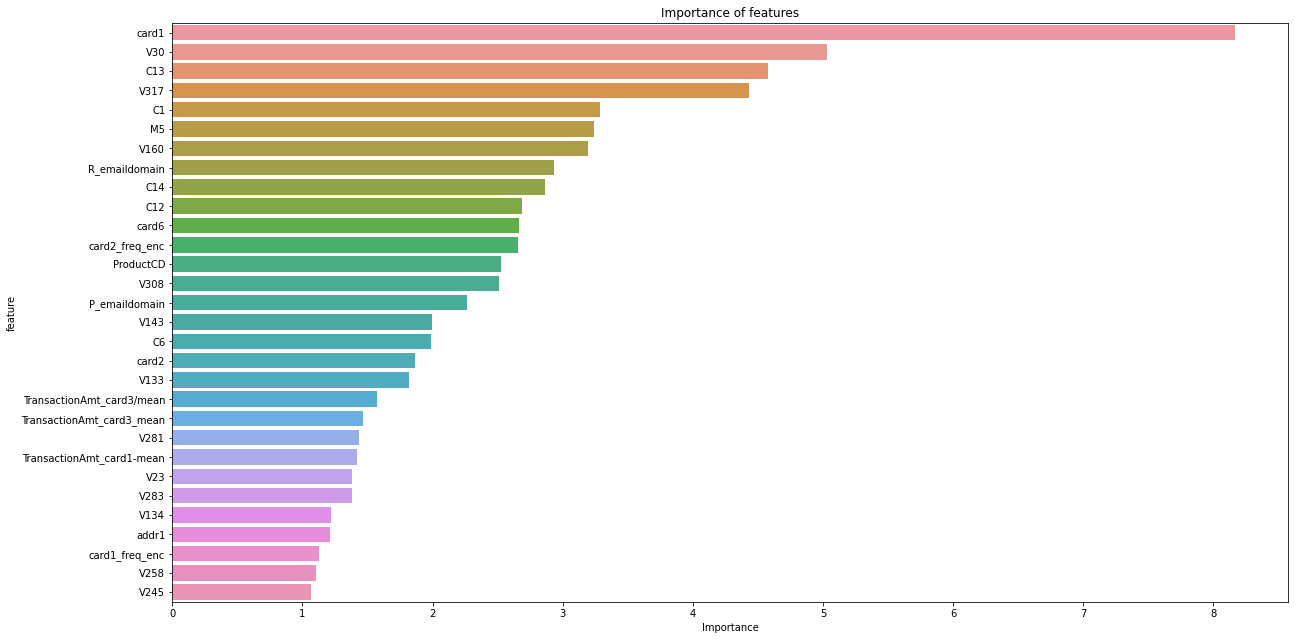

Wall time: 5.83 s


In [670]:
%%time
fit_predict(train, test)

Добавление новых признаков улучшило качество модели: 0.8751839144482718 с доверительным интервалом (0.8739895020041003, 0.9227576149074642). При этом новые признаки не попали даже в топ 30 важных признаков.

#### Задание 5:
для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

In [671]:
# Нечисловые признаки
not_num = np.hstack((train.select_dtypes("object").columns.tolist(), [target, 'TransactionID', 'TransactionDT_date']))
not_num

array(['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2',
       'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'isFraud',
       'TransactionID', 'TransactionDT_date'], dtype='<U18')

In [672]:
# Числовые признаки
num = train.columns.drop(not_num)
num

Index(['TransactionDT', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6',
       ...
       'TransactionAmt_card6-mean', 'card1_freq_enc', 'card2_freq_enc',
       'card3_freq_enc', 'card4_freq_enc', 'card5_freq_enc', 'card6_freq_enc',
       'TransactionAmt_log', 'TransactionAmt_log_whole',
       'TransactionAmt_log_fractional'],
      dtype='object', length=404)

In [673]:
def add_pca(i_train, i_test, i_num, components):
    """
    Добавление PCA-признаков

    Parameters
    ----------
    i_train: Исходная обучаемая выборка
    
    i_test: Исходная тестовая выборка
    
    i_num: Числовые поля
    
    components: Число компонент

    Returns
    -------
    i_train: Результирующая обучаемая выборка
    
    i_test: Результирующая тестовая выборка
    """
    
    # Убираем пустоты
    train_z = i_train[i_num].fillna(value=-1)
    test_z = i_test[i_num].fillna(value=-1)

    # Масштабирование
    ss = StandardScaler().fit(train_z)
    train_ss = ss.transform(train_z)
    test_ss = ss.transform(test_z)

    # PCA
    pca = PCA(n_components=components)
    pca.fit(train_ss)

    pca_fields = [f'pca_{i}' for i in range(components)]
    i_train[pca_fields] = pca.transform(train_ss)
    i_test[pca_fields] = pca.transform(test_ss)
    
    return i_train, i_test

Зададим число компонент равное 40, т.е. почти в 10 раз меньше чем 404 исходных числовых признаков.

In [674]:
train, test = add_pca(train, test, num, 40)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39
0,2987000,0,86400,68.5,W,13926,nan,150.0,discover,142.0,...,-1.152050,2.829335,-0.282072,-1.388312,0.821136,-0.993604,0.307557,-0.314810,-0.404567,-0.251975
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,-1.926234,0.838946,0.820041,-1.447007,1.092486,0.478241,-1.024837,0.179385,-0.451878,0.336650
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,-1.108006,1.593297,0.096431,-1.730384,0.577227,0.482137,-0.188327,0.012798,0.260970,-0.298724
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,3.943182,2.022457,-1.647330,-3.031315,8.664983,-1.647225,-1.103206,-6.884960,-0.145759,1.478510
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,-1.591829,1.306120,-0.021513,-1.510313,1.334488,0.547231,-0.020797,0.228390,-0.351166,0.295953


Сначала попробуем обучить модель на новых PCA признаках, исключив старые признаки.

train roc_auc = 0.9074144368471637
valid roc_auc = 0.9079751801876437
test roc_auc = 0.8825442975958566
public roc_auc = 0.8417826136280971
confidence_interval = (0.8555368271840876, 0.9077249596360444)


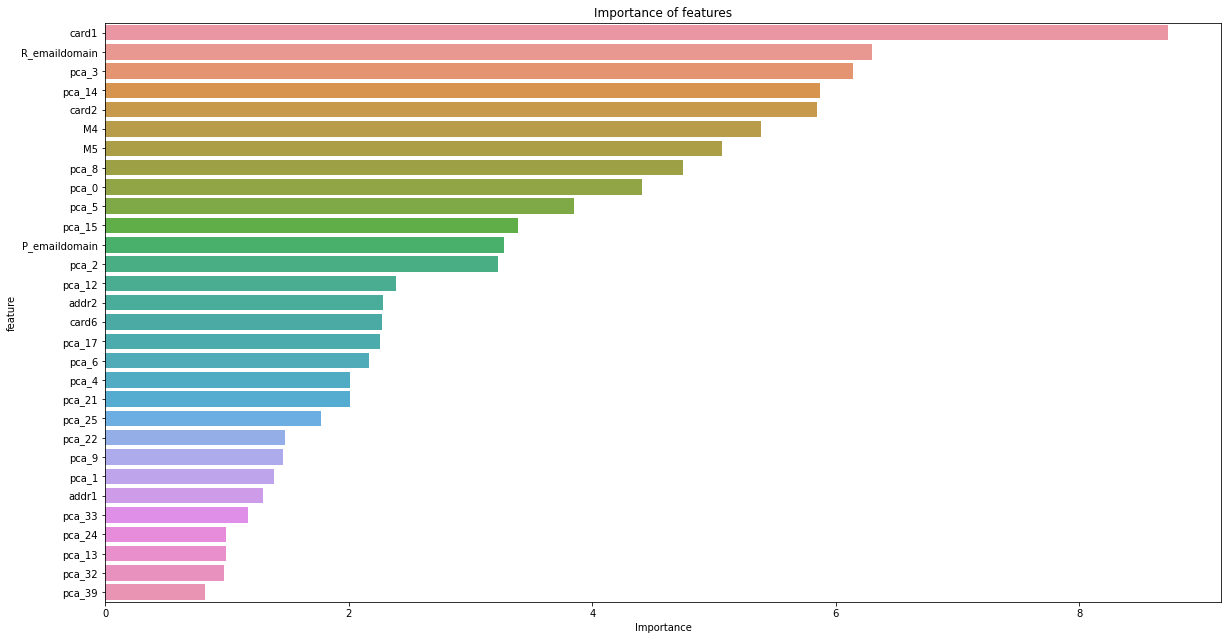

Wall time: 5.04 s


In [675]:
%%time
fit_predict(train.drop(num, axis=1), test.drop(num, axis=1))

Качество резко ухудшилось: 0.8417826136280971, при этом значение не попало в доверительный интервал (0.8555368271840876, 0.9077249596360444)

Теперь попробуем обучить на всех полях

train roc_auc = 0.9160033204341231
valid roc_auc = 0.923057481411677
test roc_auc = 0.8955512848927408
public roc_auc = 0.8761367461686036
confidence_interval = (0.8684187135651874, 0.9192316824591228)


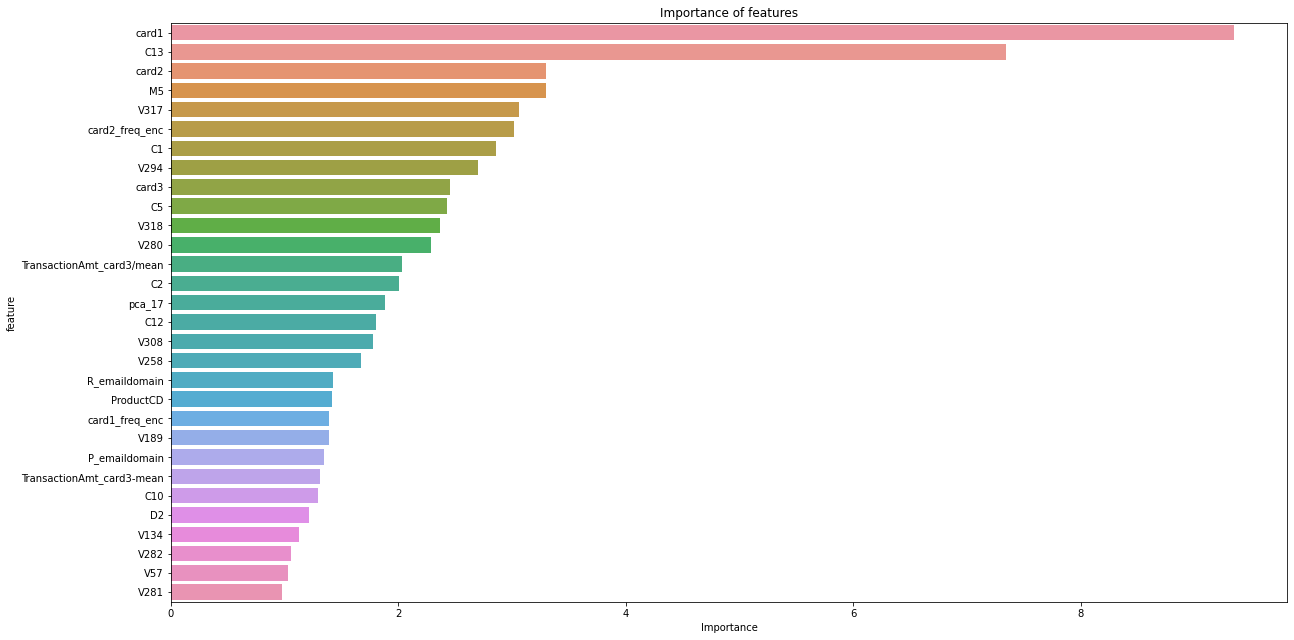

Wall time: 5.58 s


In [676]:
%%time
model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public, y_public = fit_predict_value(train, test)

При добавлении новых признаков качество модели улучшилось: 0.8761367461686036 с доверительным интервалом (0.8684187135651874, 0.9192316824591228). При этом один из новых признаков попал в топ 20 важных признаков.

#### Задание 6:
использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

In [677]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict_proba(x_valid)[:, 1] #estimator.predict(xgb.DMatrix(x_valid))
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict_proba(x_valid_copy)[:, 1] #estimator.predict(xgb.DMatrix(x_valid_copy))
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [678]:
# Возьмём модель из пункта 5
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=x_valid, y_valid=y_valid
)

100%|████████████████████████████████████████████████████████████████████████████████| 465/465 [00:35<00:00, 13.08it/s]


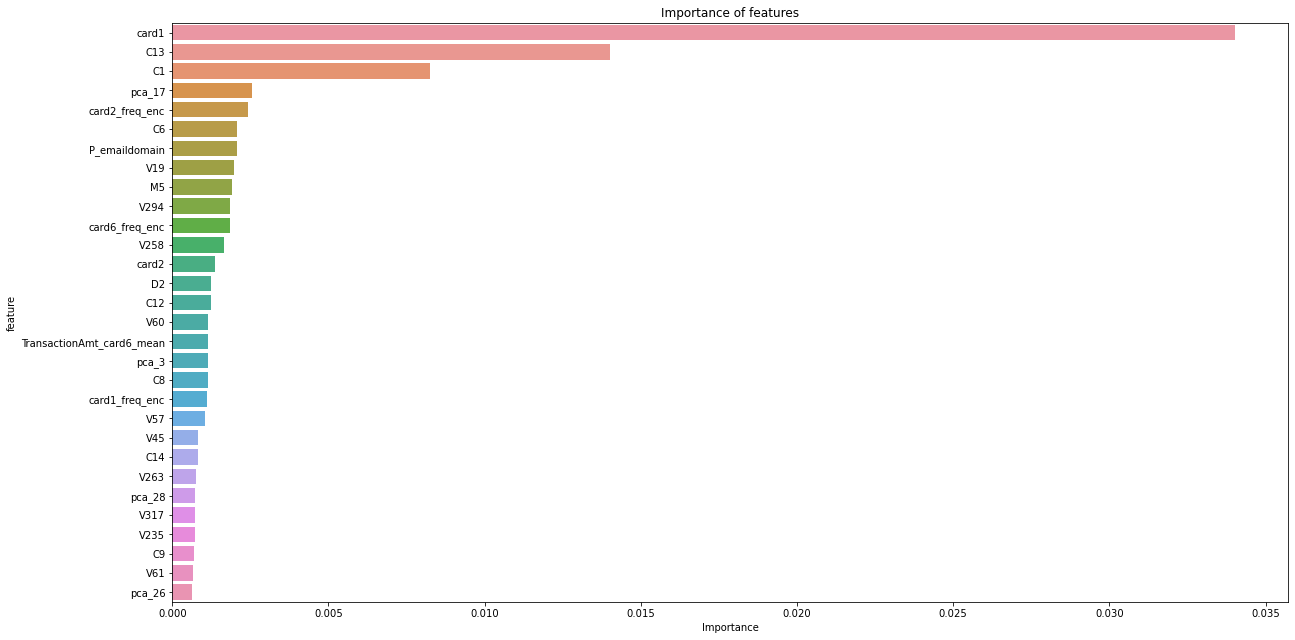

In [679]:
# Важность признаков полученных на основе перестановок
show_feature_importances(perm_importance.index, perm_importance, get_top=30)

In [680]:
len(perm_importance[perm_importance > 0.0001])

71

train roc_auc = 0.9147659023917704
valid roc_auc = 0.9230383882525941
test roc_auc = 0.8934063947181168
public roc_auc = 0.87528118770787
confidence_interval = (0.8655113191558641, 0.9192580813833973)


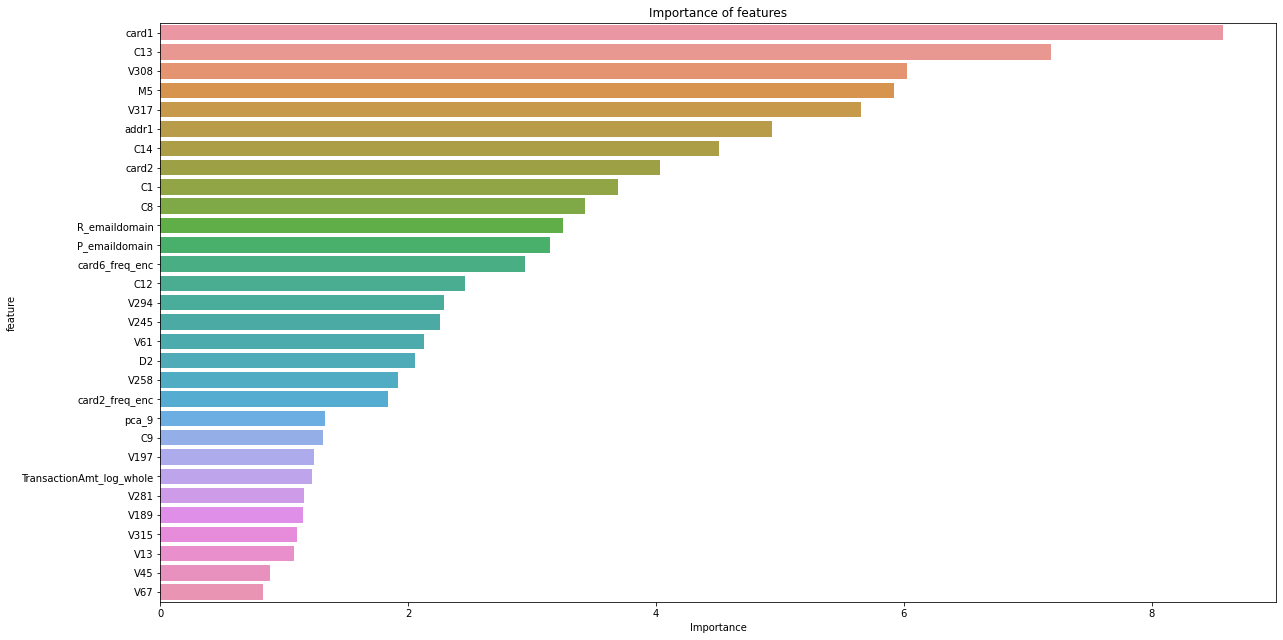

Wall time: 4.41 s


In [681]:
%%time
perm_fields = list(perm_importance[perm_importance > 0.0001].index)
perm_fields.append(target)
fit_predict(train[perm_fields], test[perm_fields])

Уменьшив число признаков с более чем 400 до 71 качество модели немного упало: 0.87528118770787 с доверительным интервалом (0.8655113191558641, 0.9192580813833973). Но это падение незначительное по сравнению с тем насколько сильно уменьшилось количество признаков. Если сравнить важность признаков полученных на основе перестановок и те важности, которые вернула сама модель, то видно, что они отличаются.

#### Задание 7: (опциональное)
использовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогноз. Проанализировать результаты.

train roc_auc = 0.9061771640189451
valid roc_auc = 0.9134639780046807
test roc_auc = 0.8927951520524455
public roc_auc = 0.8717200763912539
confidence_interval = (0.8655949011419897, 0.9170335180266586)


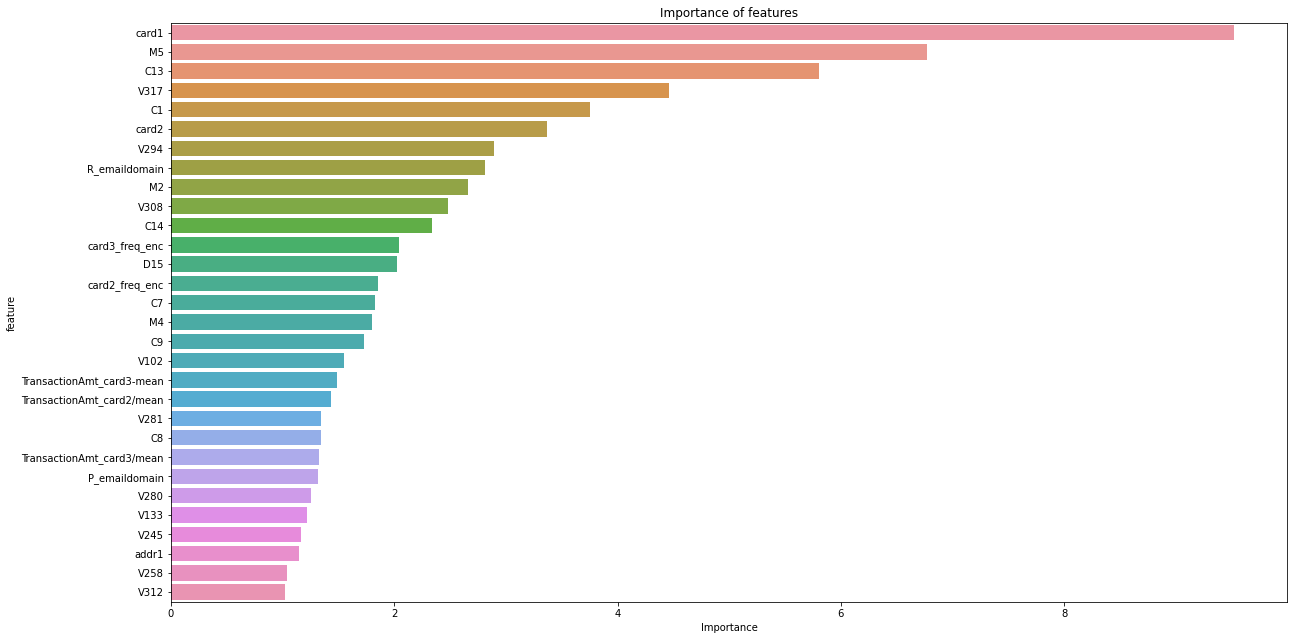

Wall time: 5.75 s


In [704]:
%%time
# SHAP ругается, что не может сериализовать дату, пришлось её исключить и обучить новую модель
columns = train.columns.drop(['TransactionDT_date']) 
model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public, y_public = \
fit_predict_value(train[columns], test[columns])

In [705]:
# Получаем данные из SHAP
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)

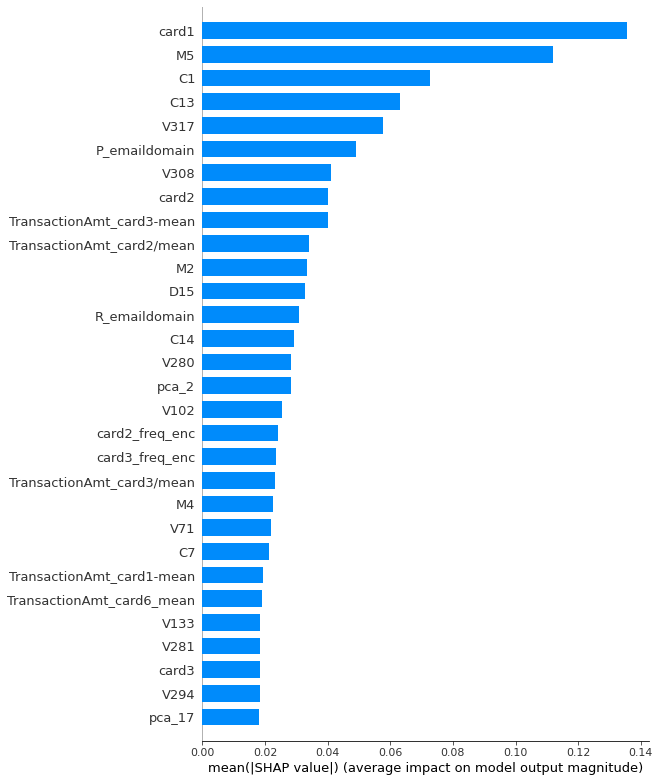

In [706]:
# Важность признаков
shap.summary_plot(shap_values, features=x_valid, plot_type='bar', max_display=30)

Видно, что важность признаков в SHAP отличается от важности признаков, которые вернула модель. Но при этом признак card1 так же как и на остальных алгоритмах определения важности является самым важным.

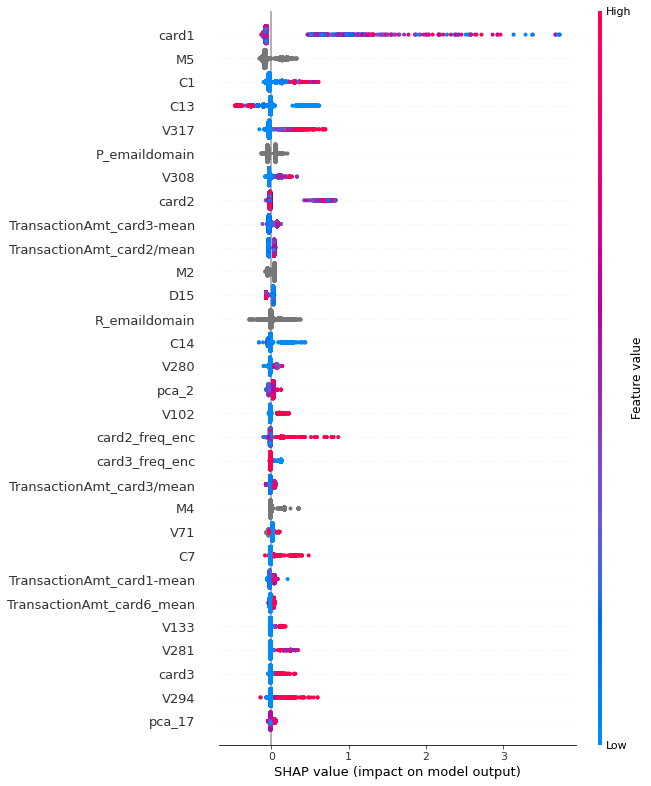

In [710]:
shap.summary_plot(shap_values, features=x_valid, max_display=30, auto_size_plot=True)

Из графика видно, что основной признак card1 имеет сложную структуру - у него нет однозначной корреляции (положительной или отрицательной) с целевой переменной, т.к. и низкие и высокие значения находятся с обеих сторон оси. И это нормально, т.к. это категориальный признак, а не цифровой. Но при этом он оказывает существенное влияние на положительный прогноз.

Признаки M5, P_emaildomain, M2, R_emaildomain, M4 сразу отмечены серым цветом - это значит, что алгоритм SHAP понял, что это категориальные признаки.

Признаки V317, V102, card2_freq_enc, V133, V281 и в какой-то степени C7 и V294 имеет значительную положительную корреляцию между значением признака и значением целевой переменной.

Признак C13 имеет отрицательную корреляцию между значением признака и значением целевой переменной.

Рассмотрим поближе строку 0

In [742]:
print(f'Истинное значение: {y_valid.iloc[0]}, предсказанное значение: {model.predict_proba([x_valid.iloc[0]])[0, 1]}')

Истинное значение: 0, предсказанное значение: 0.0058240812204626066


Видим, что модель правильно определила значение. Но посмотрим, что именно повлияло на этот результат

In [707]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_valid.iloc[0,:])

Из графика видно, что большая часть признаков оказывает понижающее влияние на значение целевой переменной и лишь значение признака C1 = 14 попыталось испортить результат.

Рассмотрим строку 35

In [759]:
print(f'Истинное значение: {y_valid.iloc[35]}, предсказанное значение: {model.predict_proba([x_valid.iloc[35]])[0, 1]}')

Истинное значение: 1, предсказанное значение: 0.030016442034312772


Видим, что модель неправильно определила значение. Посмотрим, что именно повлияло на этот результат

In [760]:
shap.force_plot(explainer.expected_value, shap_values[35,:], x_valid.iloc[35,:])

Из графика видно, что значительный вклад в повышение значения внёс признак card1 = 4,089. И это плохо, т.к. этот признак на всех алгоритмах определения важности признаков является самым важным. А в данном случае получается, что он не прав.